In [49]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from scipy import interpolate
import skimage.color
import itertools

import urllib.request as request

def plot_neigborhood(x, y, P, R):
    plt.scatter(x, y)
    plt.axis('square')
    plt.grid(True)
    plt.title('Cicle with P={p} and R={r}'.format(p=P, r=R))
    plt.xticks(np.arange(-2, 3, 1.0))
    plt.yticks(np.arange(-2, 3, 1.0))
    plt.show()
    
def load_image(url, as_gray=False):
    image_stream = request.urlopen(url)
    return skimage.io.imread(image_stream, as_gray=as_gray, plugin='pil')


url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/stratified/stratified_0174.jpg'
img = load_image(url, False)
img_gray = skimage.color.rgb2gray(img)

# Image Feature Extraction: Local Binary Patterns in Cython

# Introduction

The common goal of feature extraction is to represent the raw data as a reduced set of features that better describe their main features and attributes [1]. This way, we can reduce the dimentionality of the original input and use the new features as an input to train pattern recognition and classification techniques.

Although there are several features that we can extract from a picture, Local Binary Patterns (LBP) is a theoretically simple, yet efficient approach to gray scale and rotation invariant textur classification. They work because the most frequent patterns correspond to primitive microfeatures such as edges, corners, spots, flat regions [2].

In [2], Ojala et al. shown that the discrete occurence histogram of the uniform patterns are a very powerful texture feature. Image texture is defined as a two dimentional phenomenon characterized by two properties: (1) spatial structure (pattern) and (2) contrast.

The image that we are going to use to test each step of the methodology is the following:

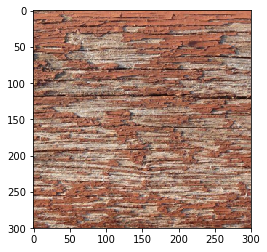

In [2]:
_ = plt.imshow(img)

# Methodology

## Circularly Symmetric Neighbor Set

A circularly symmetric neighbor set for a given pixel $g_c$ is defined by the points with coordinates (i, j) that surround the central point on a circle of radius R, and number of elements P.

$$i = -R\sin\big(\frac{2\pi p}{ P}\big);\hspace{1em}j = R\cos\big(\frac{2\pi p}{P}\big)\hspace{1em}\forall\hspace{0.5em}p \in \{0, 1, ..., P\}$$

In [3]:
def neighborhood(P, R):
    x = np.arange(0, P)
    x = R * np.cos(2 * np.pi * x / P)
    
    y = np.arange(0, P)
    y = - R * np.sin(2 * np.pi * y / P)
    
    return x, y

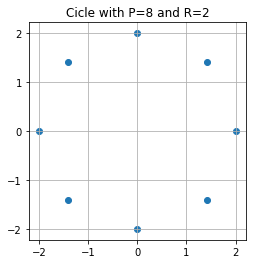

In [20]:
R = 2
P = 8

x, y = neighborhood(P, R)

plot_neigborhood(x, y, P, R)

## Texture
We define a texture *T* as the collection of pixels in a gray scale image

$$T \approx t(g_c, g_0, g_1, ..., g_{P-1})$$

where $g_p$ corresponds to the gray value of the *p* local neighboor.

## Interpolation

When a neighbor is not located in the center of a pixel, that neighbor gray value should be calculated by interpolation. Thus, we need to define a function that given a coordinate, returns the interpolated gray value.

In [21]:
def interpolate2d(gray_img, kind='cubic'):
    """
    Returns a function f(x,y) that returns the interpolated value
    of gray_img where (x,y) is the coordinate.
    """
    assert gray_img.ndim == 2, 'It should be a two dimentional image (gray)'
    h, w = gray_img.shape

    x = np.arange(0, w)
    y = np.arange(0, h)

    return interpolate.interp2d(y, x, gray_img, kind=kind)

def calculate_neiborhood_values(x, y, interpolation_function):
    gray_values = map(lambda pt: interpolation_function(*pt), zip(y, x))
    return np.fromiter(gray_values, float)

In [40]:
x0 = 180
y0 = 90

xp = x + x0
yp = y + y0

f = interpolate2d(img_gray, kind='cubic')

print('Neigborhood gray values:\n', img_gray[y0 - R: y0 + R + 1, x0 - R: x0 + R + 1])
print('\nNeighborhood interpolations:', calculate_neiborhood_values(yp, xp, f))

Neigborhood gray values:
 [[0.45338745 0.41222235 0.20437922 0.20045765 0.32594784]
 [0.38641529 0.35112118 0.37436784 0.38331216 0.44213569]
 [0.44709725 0.45915255 0.44263294 0.45494824 0.45494824]
 [0.49612824 0.47457098 0.47963137 0.49112824 0.47658078]
 [0.36322118 0.30945804 0.28259529 0.30222588 0.30701843]]

Neighborhood interpolations: [0.45494824 0.32465656 0.20437922 0.38851103 0.44709725 0.42937891
 0.28259529 0.40989396]


## Achieving Gray-Scale Invariance

Considering a possible loss of information, it is possible to turn the texture into the joint difference. To calculate it, we substract the gray value of the central pixel to all of the neighbor set. The joint difference distribution is a highly discriminative texture operator. It records the ocurrences of various patterns in the neighborhood of each pixel in a P-dimentional histogram.

$$T \approx t(g_0 - g_c, g_1 - g_c, ... g_{P-1} - g_c)$$

where $g_0$ is the gray value of the center pixel and $g_p$ is the gray value of the $p$ neighbor. This distribution is invariant against gray-scale shifts.

In [41]:
def joint_difference_distribution(gray_img, gc, x, y, interpolation_f):
    xc, yc = gc
    
    xp = xc + x
    yp = yc + y
    
    g_p = calculate_neiborhood_values(xp, yp, interpolation_f)
    g_c = interpolation_f(xc, yc)
    
    return np.round(g_p - g_c, 15)

In [42]:
print('The joint difference distribution is:\n', joint_difference_distribution(img_gray, (x0, y0), x, y, f))

The joint difference distribution is:
 [ 0.09568275  0.05831416 -0.02403451 -0.00531706  0.0429902  -0.04441044
 -0.00746941  0.01027906]


## Local Binary Pattern

$LBP_{P,R}$ operater is by definition invariant against any monotonic transformation of the gray scale. As long as the order of the gray values stays the same, the output of the $LBP_{P,R}$ operator remains constant.

$$LBP_{P,R} = \sum_{p=0}^{P-1} s(g_p - g_c) 2^p$$

where 

$$s(x) = 
\begin{cases} 
    1 & x\geq0 \\
    0 & x<0
\end{cases}
$$

In [43]:
def binary_joint_distribution(gray_img, gc, x, y, interpolation_f):
    T = joint_difference_distribution(gray_img, gc, x, y, interpolation_f)
    return np.where(T >= 0, 1, 0)

def LBP(gray_img, gc, x, y, interpolation_f):
    s = binary_joint_distribution(gray_img, gc, x, y, interpolation_f)
    p = np.arange(0, P)
    binomial_factor = 2 ** p
    return np.sum(binomial_factor * s)

In [44]:
print('The joint difference distribution is:\n', joint_difference_distribution(img_gray, (x0, y0), x, y, f))
print('The binary joint distribution is:\n', binary_joint_distribution(img_gray, (x0, y0), x, y, f))
print('LBP:\n', LBP(img_gray, (x0, y0), x, y, f))

The joint difference distribution is:
 [ 0.09568275  0.05831416 -0.02403451 -0.00531706  0.0429902  -0.04441044
 -0.00746941  0.01027906]
The binary joint distribution is:
 [1 1 0 0 1 0 0 1]
LBP:
 147


### Uniform Local Binary Patterns

In [2], Ojala mentions that in their practical experience LBP is not a good discriminator. They propose just to select the set of local binary patterns such that the number of spatial transitions (bitwise 0/1 changes) does not exeed 2. 

For example, the pattern '1111' has 0 spatial transitions, the pattern '1100' has 1 spatial transitions and the pattern '1101' has 2 spatial transitions. Thus, the uniform local binary patterns are defined as:

$$LBP_{P,R}^{u2} = 
\begin{cases} 
    \sum_{p=0}^{P-1} s(g_p - g_c) & U(LBP_{P,R}) \leq 2 \\
    P + 1 & otherwise,
\end{cases}
$$

where

$$U(LBP_{P, R}) = |s(g_{P-1} - g_c) - s(g_0 - g_c)| + \sum_{p=1}^{P-1} |s(g_p - g_c) - s(g_{p-1} - g_c)|$$

Given that the number of uniform patterns is finite. We can create a hash table with the uniform patterns.

In [47]:
def is_uniform(pattern):
    count = 0
    for idx in range(len(pattern) - 1):
        count += pattern[idx] ^ pattern[idx + 1]
        if count > 2:
            return False
    return True

def uniform_patterns(P):
    patterns = itertools.product([0, 1], repeat=P)
    u_patterns = [pattern for pattern in patterns if is_uniform(pattern)]
    
    return [''.join(str(elem) for elem in elems) for elems in u_patterns]

def LBP_uniform(gray_img, gc, x, y, interpolation_f, uniform_patterns):
    s = binary_joint_distribution(gray_img, gc, x, y, f)
    pattern = ''.join([str(elem) for elem in s])
    p = np.arange(0, P)
    binomial_factor = 2 ** p
    
    return sum(s) if pattern in uniform_patterns else P + 1

In [51]:
u_patterns = uniform_patterns(P)

print('The joint difference distribution is:\n', joint_difference_distribution(img_gray, (x0, y0), x, y, f))
s_T = binary_joint_distribution(img_gray, (x0, y0), x, y, f)
print('The binary joint distribution is:\n', s_T)
print('LBP:\n', LBP(img_gray, (x0, y0), x, y, f))
print('Is {} a uniform pattern: {}\n'.format(s_T, is_uniform(s_T)))
print('LBP_uniform:', LBP_uniform(img_gray, (x0, y0), x, y, f, u_patterns))

The joint difference distribution is:
 [ 0.09568275  0.05831416 -0.02403451 -0.00531706  0.0429902  -0.04441044
 -0.00746941  0.01027906]
The binary joint distribution is:
 [1 1 0 0 1 0 0 1]
LBP:
 147
Is [1 1 0 0 1 0 0 1] a uniform pattern: False

LBP_uniform: 9


## Cython Code

In [ ]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp

from libc.math cimport sin, cos, pi, ceil, floor, pow
from libc.stdlib cimport abort, malloc, free
from libc.stdio cimport printf
import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import prange, parallel
cimport openmp


cdef double get_pixel2d(
    double *image,
    Py_ssize_t n_rows, 
    Py_ssize_t n_cols,
    long x,
    long y) nogil:
    
    if (y < 0) or (y >= n_rows) or (x < 0) or (x >= n_cols):
        return 0
    else:
        return image[y * n_cols + x]

    
cdef double bilinear_interpolation(
    double *image,
    Py_ssize_t n_rows,
    Py_ssize_t n_cols,
    double x,
    double y) nogil:
    
    cdef double d_y, d_x, top_left, top_right, bottom_left, bottom_right
    cdef long min_y, min_x, max_y, max_x

    min_y = <long>floor(y)
    min_x = <long>floor(x)
    max_y = <long>ceil(y)
    max_x = <long>ceil(x)
    
    d_y = y - min_y
    d_x = x - min_x
    
    top_left = get_pixel2d(image, n_rows, n_cols, min_x, min_y)
    top_right = get_pixel2d(image, n_rows, n_cols, max_x, min_y)
    bottom_left = get_pixel2d(image, n_rows, n_cols, min_x, max_y)
    bottom_right = get_pixel2d(image, n_rows, n_cols, max_x, max_y)
    
    top = (1 - d_x) * top_left + d_x * top_right
    bottom = (1 - d_x) * bottom_left + d_x * bottom_right

    return (1 - d_y) * top + d_y * bottom


cdef double *joint_difference_distribution(
    double *image,
    Py_ssize_t n_rows,
    Py_ssize_t n_cols,
    int x0,
    int y0,
    int P,
    int R
) nogil:
    cdef Py_ssize_t p
    cdef double *T = <double *> malloc(sizeof(double) * P)
    cdef double x, y, gp, gc
    
    if T is NULL:
        abort()
        
    gc = get_pixel2d(image, n_rows, n_cols, x0, y0)
    
    for p in range(P):
        x = x0 + R * cos(2 * pi * p / P)
        y = y0 - R * sin(2 * pi * p / P)
        gp = bilinear_interpolation(image, n_rows, n_cols, x, y)
        T[p] = gp - gc
    
    return T


cdef int *binary_joint_distribution(double *T, Py_ssize_t T_size) nogil:
    cdef int *s_T = <int *> malloc(sizeof(int) * T_size)
    cdef Py_ssize_t i = 0
    
    for t in range(T_size):
        if T[t] >= 0.0:
            s_T[t] = 1
        else:
            s_T[t] = 0
    
    return s_T


cdef long LBP(double *T, int *s_T, Py_ssize_t T_size) nogil:
    cdef long LBP_pr = 0
    cdef Py_ssize_t i = 0
    
    for i in range(0, T_size):
        LBP_pr = LBP_pr + 2 ** i * s_T[i]
        
    return LBP_pr


cdef int is_uniform_pattern(int *s_T, Py_ssize_t s_T_size) nogil:
    cdef Py_ssize_t i = 0
    cdef int counter = 0
    
    for i in range(s_T_size - 1):
        if s_T[i] != s_T[i + 1]:
            counter += 1
        
        if counter > 2:
            return 0
    return 1


cdef int create_index(int *s_T, Py_ssize_t s_T_size) nogil:
    cdef int n_ones = 0
    cdef int rot_index = -1
    cdef int first_one = -1
    cdef int first_zero = -1
    cdef int lbp = -1

    cdef Py_ssize_t i
    for i in range(s_T_size):
        if s_T[i]:
            n_ones += 1
            if first_one == -1:
                first_one = i
        else:
            if first_zero == -1:
                first_zero = i
    
    if n_ones == 0:
        lbp = 0
    elif n_ones == s_T_size:
        lbp = s_T_size * (s_T_size - 1) + 1
    else:
        if first_one == 0:
            rot_index = n_ones - first_zero
        else:
            rot_index = s_T_size - first_one
        lbp = 1 + (n_ones - 1) * s_T_size + rot_index
    return lbp


cdef int LBP_uniform(int *s_T, Py_ssize_t s_T_size) nogil:
    cdef int LBP_pru = 0
    cdef Py_ssize_t i = 0
    
    if is_uniform_pattern(s_T, s_T_size):
        LBP_pru = create_index(s_T, s_T_size)
    else:
        LBP_pru = 2 + s_T_size * (s_T_size - 1)
        
    return LBP_pru


@cython.boundscheck(False)
@cython.wraparound(False)
cdef int *local_binary_patterns(
    double *image,
    Py_ssize_t n_rows,
    Py_ssize_t n_cols,
    int P,
    int R
) nogil:
    cdef Py_ssize_t x = 0
    cdef Py_ssize_t y = 0
    cdef int *lbp = <int *> malloc(sizeof(int) * n_rows * n_cols)
    
    if lbp is NULL:
        abort()
    
    cdef int num_threads = openmp.omp_get_num_threads()
    
    with nogil, parallel(num_threads=num_threads):
        for y in prange(n_rows, schedule='static'):
            for x in prange(n_cols, schedule='static'):
                T = joint_difference_distribution(image, n_rows, n_cols, x, y, P, R)
                s_T = binary_joint_distribution(T, P)
                lbp[y * n_cols + x] = LBP_uniform(s_T, P)
            
    return lbp


def bilinear_interpolation_python(double[:, ::1] image, double x, double y):
    cdef Py_ssize_t n_rows
    cdef Py_ssize_t n_cols
    
    n_rows = image.shape[0]
    n_cols = image.shape[1]
    
    return bilinear_interpolation(&image[0][0], n_rows, n_cols, x, y)


def joint_difference_distribution_python(double[:, ::1] image,int x0, int y0, int P, int R):
    cdef Py_ssize_t n_rows, n_cols
    n_rows = image.shape[0]
    n_cols = image.shape[1]
    
    T = joint_difference_distribution(&image[0][0], n_rows, n_cols, x0, y0, P, R)
    
    s_T = binary_joint_distribution(T, P)
    
    return [p for p in s_T[:P]]


cpdef long LBP_python(double[:, ::1] image, int x0, int y0, int P, int R):
    cdef Py_ssize_t n_rows
    cdef Py_ssize_t n_cols
    cdef Py_ssize_t i
    cdef long LBP_pr
    
    n_rows = image.shape[0]
    n_cols = image.shape[1]
    
    T = joint_difference_distribution(&image[0][0], n_rows, n_cols, x0, y0, P, R)
    s_T = binary_joint_distribution(T, P)
    LBP_pr = LBP(T, s_T, P)
    
    return LBP_pr

cpdef int create_index_python(int[:] s_T, int P):
    return create_index(&s_T[0], P)

cpdef int is_uniform_pattern_python(int[:] s_T, int P):
    return is_uniform_pattern(&s_T[0], P)

cpdef long LBP_uniform_python(double[:, ::1] image, int x0, int y0, int P, int R):
    cdef Py_ssize_t n_rows
    cdef Py_ssize_t n_cols
    cdef Py_ssize_t i
    
    n_rows = image.shape[0]
    n_cols = image.shape[1]
    
    T = joint_difference_distribution(&image[0][0], n_rows, n_cols, x0, y0, P, R)
    s_T = binary_joint_distribution(T, P)
    LBP_pru = LBP_uniform(s_T, P)
    
    return LBP_pru


cpdef local_binary_patterns_python(double[:, ::1] image, int P, int R):
    cdef Py_ssize_t n_rows
    cdef Py_ssize_t n_cols
    
    n_rows = image.shape[0]
    n_cols = image.shape[1]
    
    cdef np.ndarray LBP_u = np.zeros([n_rows, n_cols], dtype=np.int32)
    cdef Py_ssize_t i
    cdef Py_ssize_t j
    
    LBP_u_pointer = local_binary_patterns(&image[0][0], n_rows, n_cols, P, R)
    
    for j in range(n_rows):
        for i in range(n_cols):
            LBP_u[j, i] = LBP_u_pointer[n_cols * j + i]
    
    return LBP_u

# Bibliography

    [1] Marques, O. (2011). Practical image and video processing using MATLAB. John Wiley & Sons.
    [2] Ojala, T., Pietikäinen, M., & Mäenpää, T. (2002). Multiresolution gray-scale and rotation invariant texture classification with local binary patterns. IEEE Transactions on Pattern Analysis and Machine Intelligence, 24(7), 971–987.